In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torchvision.transforms as T
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import albumentations as A
from tensorflow.keras import Model, layers
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

In [27]:
images = images = np.load("images.npy")
labels = pd.read_csv("labels.csv")

In [28]:
print(images.shape)

(4750, 128, 128, 3)


In [29]:
print(labels.shape)

(4750, 1)


In [30]:
labeled_dataset= list(zip(images, labels))

In [31]:
unique, counts = np.unique(labels, return_counts=True)
print(np.asarray((unique, counts)).T)

[['Black-grass' 263]
 ['Charlock' 390]
 ['Cleavers' 287]
 ['Common Chickweed' 611]
 ['Common wheat' 221]
 ['Fat Hen' 475]
 ['Loose Silky-bent' 654]
 ['Maize' 221]
 ['Scentless Mayweed' 516]
 ['Shepherds Purse' 231]
 ['Small-flowered Cranesbill' 496]
 ['Sugar beet' 385]]


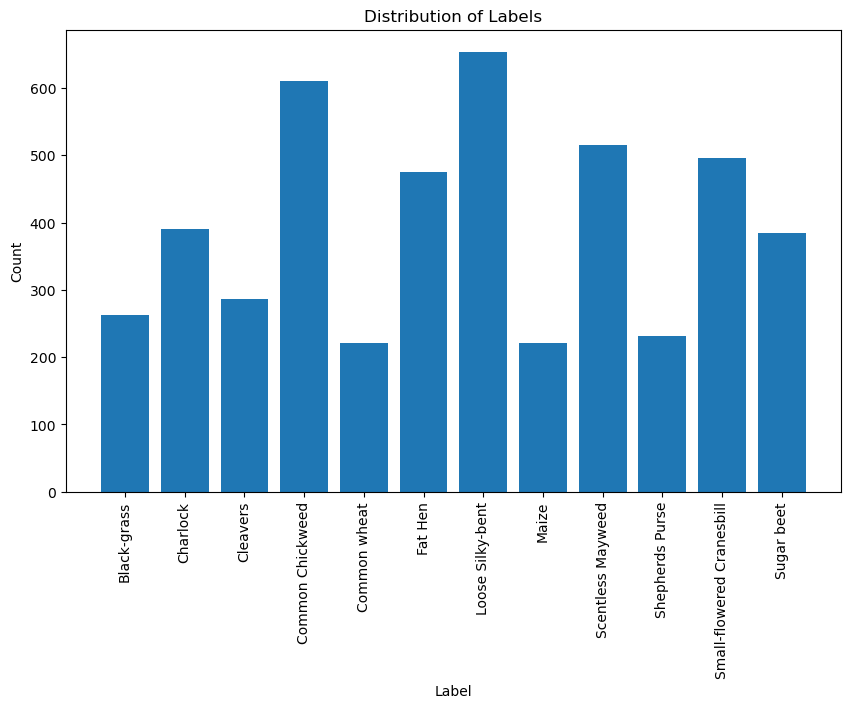

In [32]:
plt.figure(figsize=(10, 6))
plt.bar(unique, counts)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(unique, rotation=90) #horizontal looked bad
plt.show()

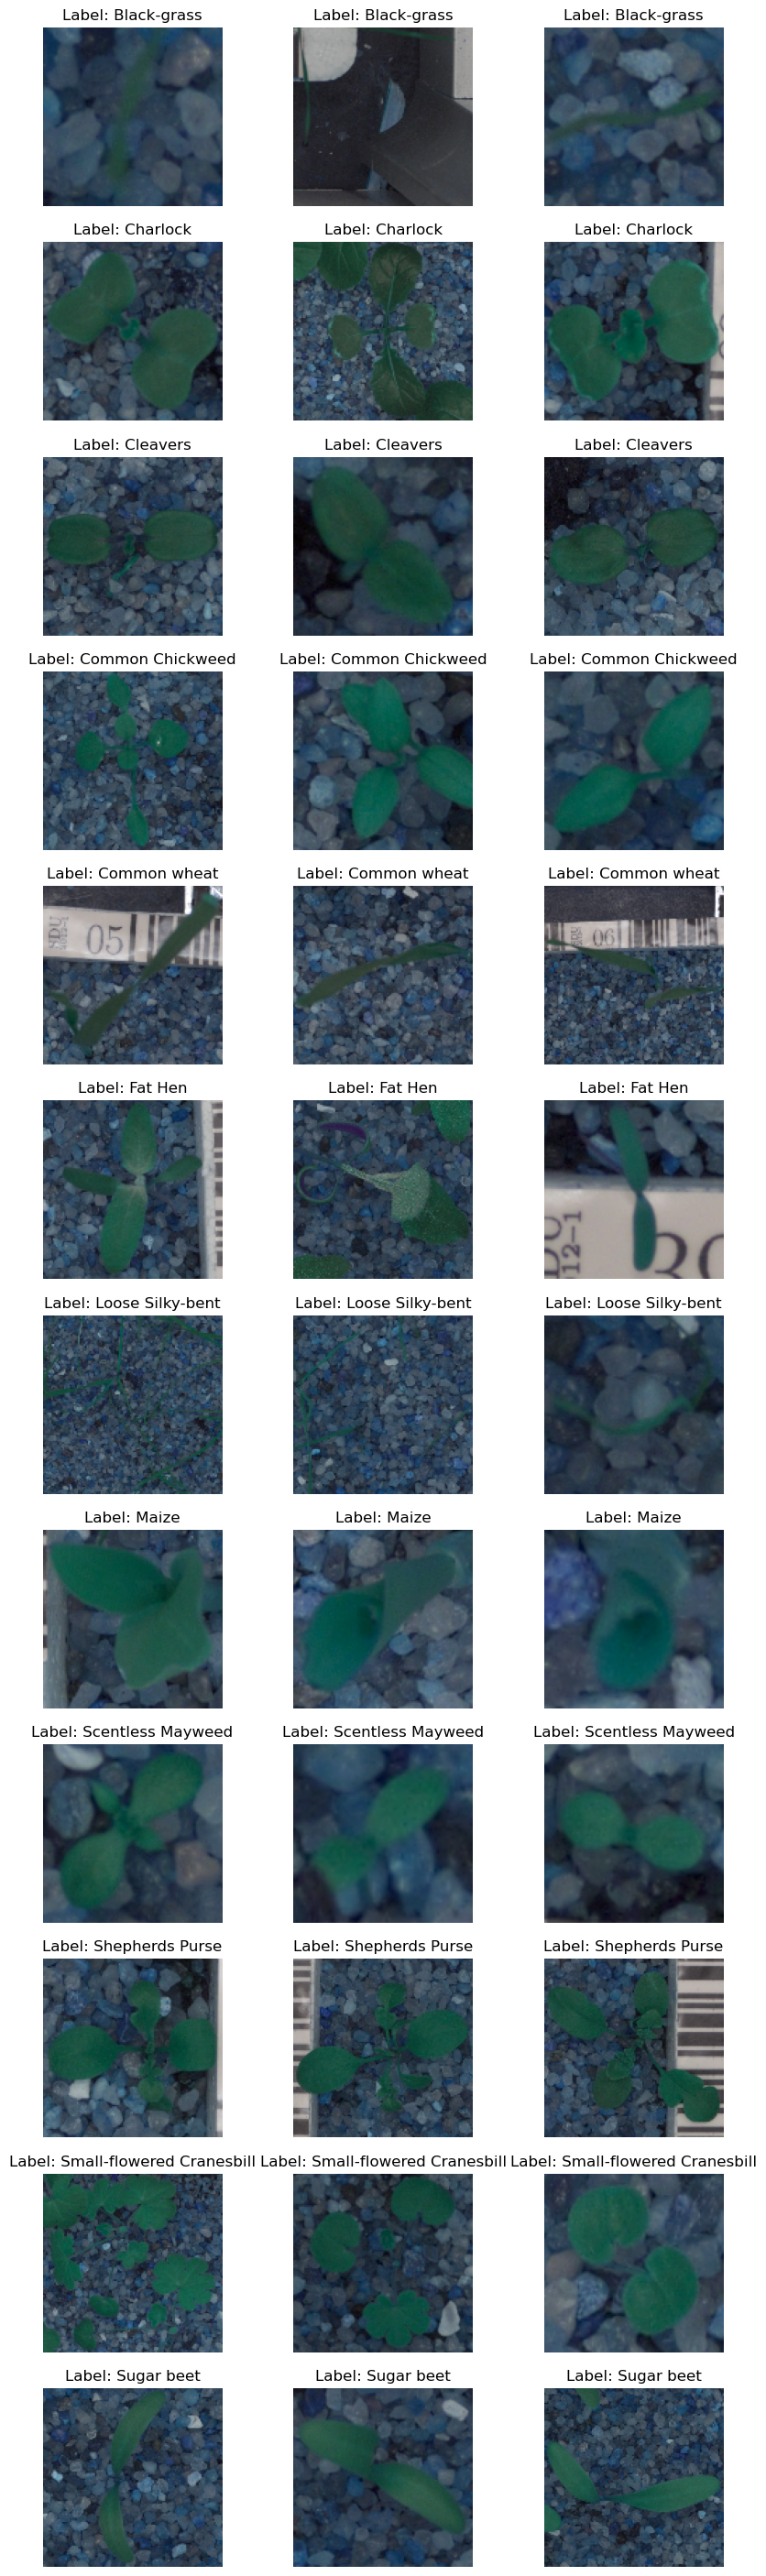

In [33]:
def show_sample_images(images, labels, num_per_class=3):
    unique_labels = np.unique(labels)
    
    n_labels = len(unique_labels)
    fig, axes = plt.subplots(n_labels, num_per_class, figsize=(10, 3*n_labels))
    
    # For each label
    for i, label in enumerate(unique_labels):
        # Find all images with this label
        label_indices = np.where(labels == label)[0]
        
        # Get random samples for this label
        sample_indices = np.random.choice(label_indices, size=min(num_per_class, len(label_indices)), replace=False)
        
        # Plot each sample
        for j, idx in enumerate(sample_indices):
            ax = axes[i][j] if n_labels > 1 else axes[j]
            ax.imshow(images[idx])
            ax.axis('off')
            ax.set_title(f'Label: {label}')
    
    plt.show()

# Use the function
show_sample_images(images, labels)

In [34]:
# Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2])
       
datagen.fit(images)




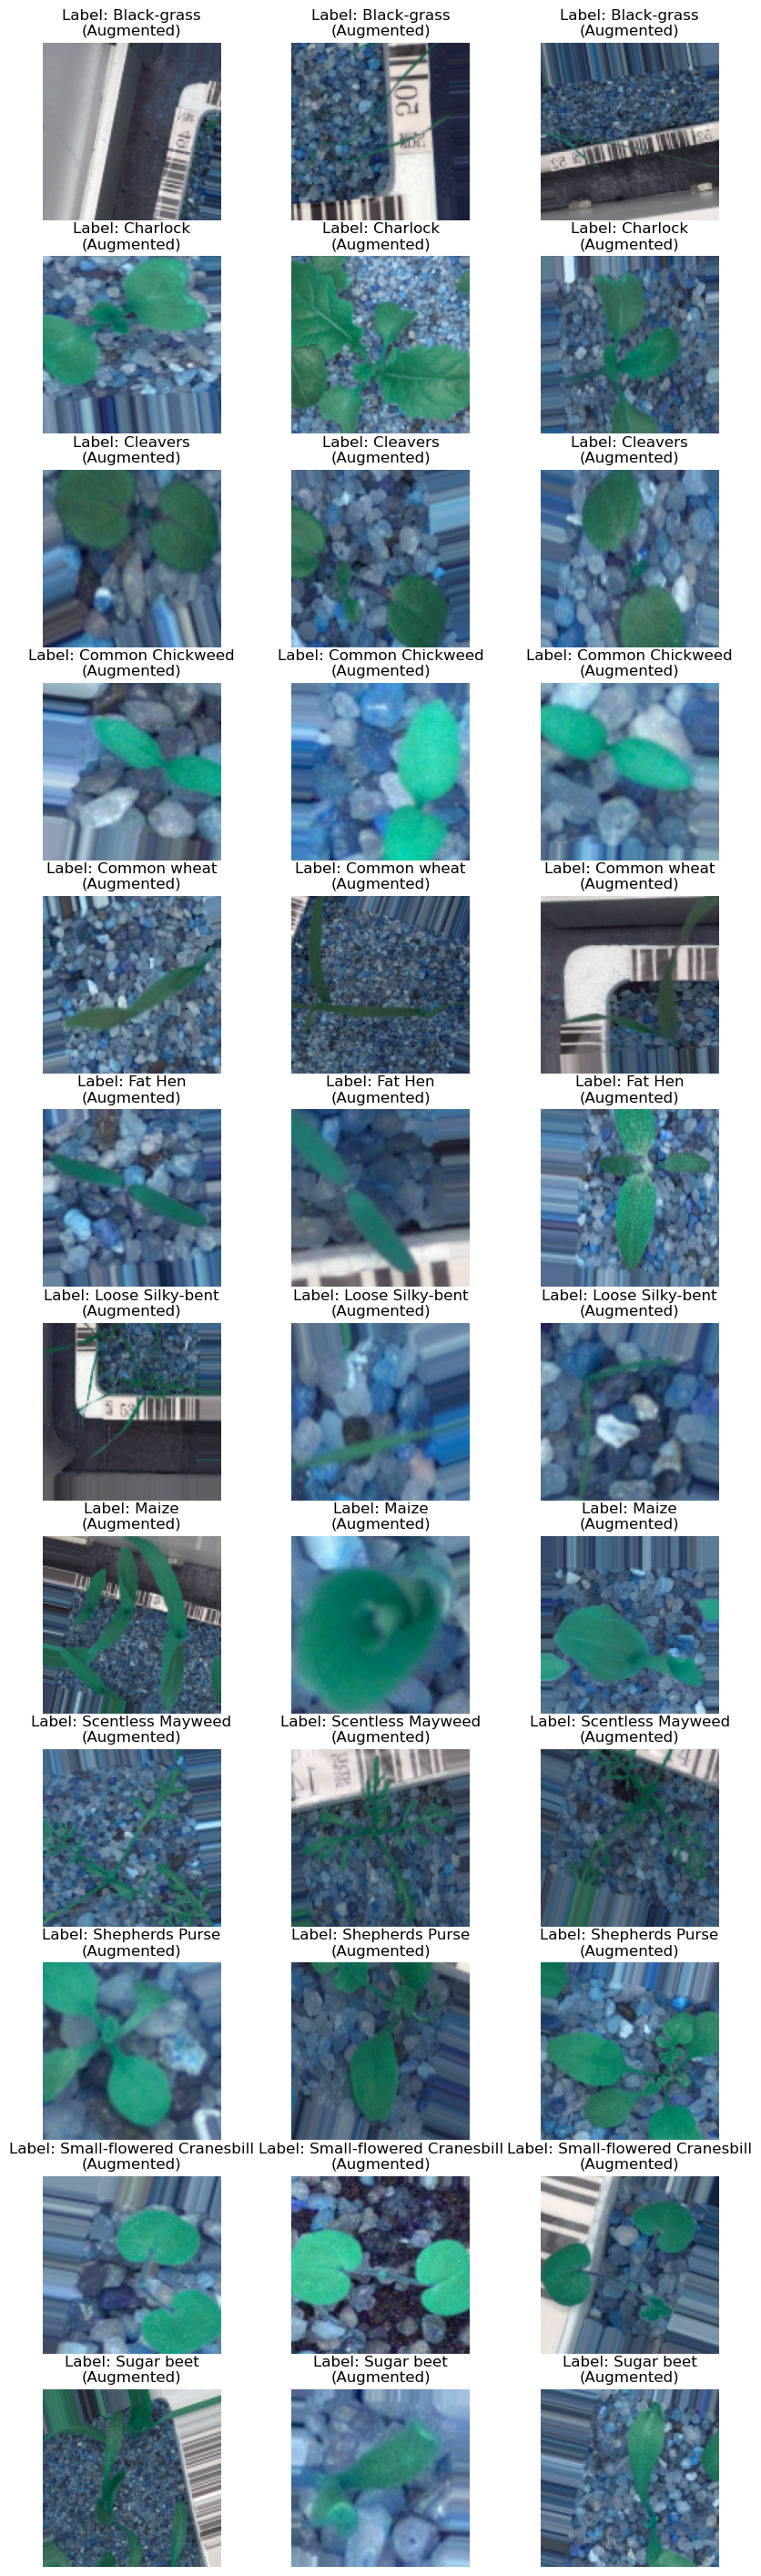

In [35]:
def show_augmented_samples(images, labels, datagen, num_per_class=3):
    unique_labels = np.unique(labels)
    n_labels = len(unique_labels)
    
    fig, axes = plt.subplots(n_labels, num_per_class, figsize=(10, 3*n_labels))
    
    # For each label
    for i, label in enumerate(unique_labels):
        # Find all images with this label
        label_indices = np.where(labels == label)[0]
        
        # Get random samples for this label
        sample_indices = np.random.choice(label_indices, size=min(num_per_class, len(label_indices)), replace=False)
        
        # Plot each sample
        for j, idx in enumerate(sample_indices):
            ax = axes[i][j] if n_labels > 1 else axes[j]
            
            # Get the original image and reshape it for the generator
            img = images[idx]
            img = img.reshape((1,) + img.shape)
            
            # Get an augmented version
            augmented_img = next(datagen.flow(img, batch_size=1))[0]
            
            # Normalize the image to [0, 1] range
            augmented_img = (augmented_img - augmented_img.min()) / (augmented_img.max() - augmented_img.min())
            
            ax.imshow(augmented_img)
            ax.axis('off')
            ax.set_title(f'Label: {label}\n(Augmented)')
    
    plt.show()
# Use the function
show_augmented_samples(images, labels, datagen)

In [36]:
# Normalizing Pixels from 0-1
images = images / 255

# Label Encoding 
label_encoder = LabelEncoder()
labels_numeric = label_encoder.fit_transform(labels['Label']) 

# Switching to one-hot encoding
labels_encoded = to_categorical(labels_numeric, num_classes=12) 
# Train/test splits
X_train, X_temp, y_train, y_temp = train_test_split(images, labels_encoded, test_size=0.3, random_state=1, stratify=labels_encoded)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp)

In [101]:
# Saving datasets
np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)

np.save("X_val.npy", X_val)
np.save("y_val.npy", y_val)

np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)

In [38]:
# Initializing Model

model = Sequential([
    # First Convolutional Layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    
    # Second Convolutional Layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Third Convolutional Layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Fourth Convolutional Layer
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Flatten layer
    Flatten(),
    
    # Dense layers
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(12, activation='softmax')
])


C:\Users\1isad\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
# Compile the model
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [40]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,569,740 (5.99 MB)

 Trainable params: 1,569,740 (5.99 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
for i, layer in enumerate(model.layers):
    weights = layer.get_weights()  # Get all weights without unpacking
    if weights:  # If the layer has any weights
        print(f"\nLayer {i} ({layer.name}):")
        print(f"Number of weight arrays: {len(weights)}")
        for j, w in enumerate(weights):
            print(f"Weight array {j} shape: {w.shape}")


Layer 0 (conv2d):
Number of weight arrays: 2
Weight array 0 shape: (3, 3, 3, 32)
Weight array 1 shape: (32,)

Layer 2 (conv2d_1):
Number of weight arrays: 2
Weight array 0 shape: (3, 3, 32, 64)
Weight array 1 shape: (64,)

Layer 4 (conv2d_2):
Number of weight arrays: 2
Weight array 0 shape: (3, 3, 64, 128)
Weight array 1 shape: (128,)

Layer 6 (conv2d_3):
Number of weight arrays: 2
Weight array 0 shape: (3, 3, 128, 256)
Weight array 1 shape: (256,)

Layer 9 (dense):
Number of weight arrays: 2
Weight array 0 shape: (9216, 128)
Weight array 1 shape: (128,)

Layer 11 (dense_1):
Number of weight arrays: 2
Weight array 0 shape: (128, 12)
Weight array 1 shape: (12,)


In [42]:
#early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.001,
    mode='min',             
    restore_best_weights=True)

In [43]:
#class weights
if len(labels_encoded.shape) > 1:
    labels_encoded = np.argmax(labels_encoded, axis=1)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_encoded),
    y=labels_encoded
)
class_weights_dict = dict(enumerate(class_weights))

In [44]:
#Model Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,                  
    batch_size=32,
    class_weight = class_weights_dict,
    callbacks=[early_stopping] 
)

Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 28s 236ms/step - accuracy: 0.0937 - loss: 2.4836 - val_accuracy: 0.0997 - val_loss: 2.3179
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - accuracy: 0.1834 - loss: 2.1389 - val_accuracy: 0.3034 - val_loss: 1.8160
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 22s 212ms/step - accuracy: 0.3045 - loss: 1.8302 - val_accuracy: 0.4298 - val_loss: 1.5377
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 22s 211ms/step - accuracy: 0.4154 - loss: 1.6236 - val_accuracy: 0.5576 - val_loss: 1.2999
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 22s 210ms/step - accuracy: 0.4948 - loss: 1.4178 - val_accuracy: 0.6390 - val_loss: 1.0767
Epoch 6/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 22s 211ms/step - accuracy: 0.5521 - loss: 1.2512 - val_accuracy: 0.6039 - val_loss: 1.1399
Epoch 7/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 22s 210ms/step - accuracy: 0.5764 - loss: 1.1815 - val_accuracy: 0.6784 - val_loss: 0.9221
Epoch 8/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 22s 210ms/step - accuracy: 0.6060 -

104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step


<Figure size 1000x800 with 0 Axes>

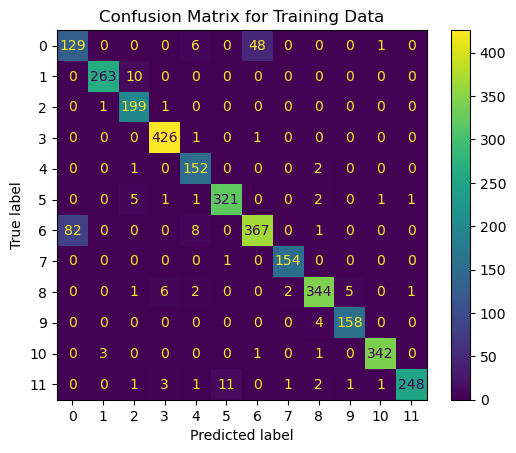

In [45]:
y_pred = model.predict(X_train)

y_pred_classes = np.argmax(y_pred, axis=1)

y_train_classes = np.argmax(y_train, axis=1) if len(y_train.shape) > 1 else y_train

cm = confusion_matrix(y_train_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix for Training Data')
plt.show()

In [75]:
print(f"Training Accuracy: {accuracy_score(y_train_classes, y_pred_classes):.4f}")

Training Accuracy: 0.9332


In [89]:
#validation predict
y_val_classes = np.argmax(y_val, axis=1) if len(y_val.shape) > 1 else y_val

yvalpred = model.predict(X_val)
yvalpred_classes = np.argmax(yvalpred, axis=1)
print(f"Validation Accuracy: {accuracy_score(y_val_classes, yvalpred_classes):.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
Validation Accuracy: 0.8174


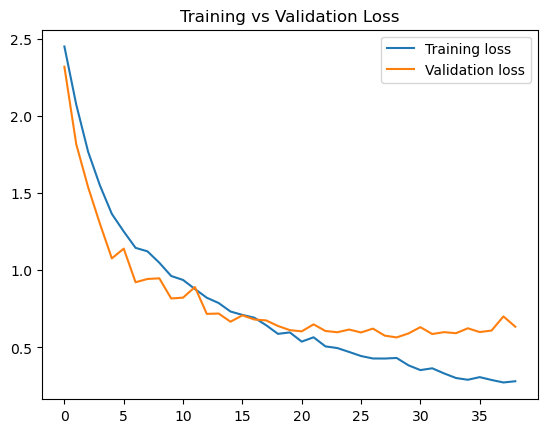

In [87]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

In [93]:
#Test predict
y_test_classes = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test
ytestpred = model.predict(X_test)
ytestpred_classes = np.argmax(ytestpred, axis = 1)
print(f"Test Accuracy: {accuracy_score(y_test_classes, ytestpred_classes):.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Test Accuracy: 0.8050


<Figure size 1000x800 with 0 Axes>

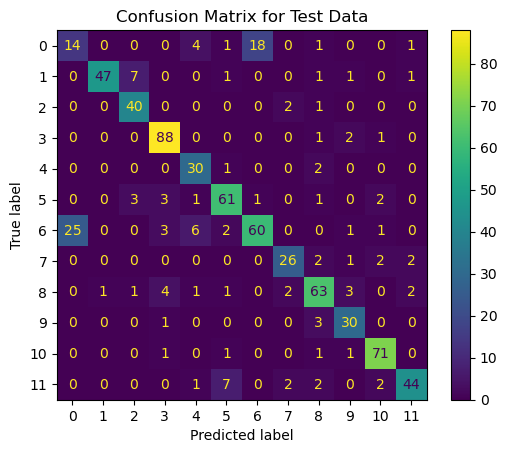

In [99]:
cm = confusion_matrix(y_test_classes, ytestpred_classes)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix for Test Data')
plt.show()